Using DASK for centralized power method

In [1]:
import numpy as np
from numpy import linalg as LA
from numpy.linalg import inv
import matplotlib.pyplot as plt
import time
import dask
import dask.array as da

In [2]:
def power(A,x_init,Eigvec):
    T=150
    error=np.zeros(T)
    y = x_init
    for t in range (T):
        y= np.matmul(A,y)
        y=y/LA.norm(y)
        error[t]=1-np.square(np.dot(Eigvec.transpose(),y)/LA.norm(y))# 1-cos^2
    return error

In [3]:
def power_parallel(s,dim,VarianceConditioning,n,chunk_size,x_init,Eigvec):
    A= np.zeros((n,), dtype=np.object)
    for i in range(n):
        Y=s[:,i*chunk_size:(i+1)*chunk_size]
        Y = np.matmul(VarianceConditioning, Y)
        A[i]=np.matmul(Y,Y.transpose())
        
    T=150
    error=np.zeros(T)
    v=np.zeros((n,dim,1))
    y = x_init
    for t in range (T):
        for i in range(n):
            v[i,:,:]= np.matmul(A[i],y)
            v[i,:,:]=v[i,:,:]/LA.norm(v[i,:,:])
                        
        y=np.sum(v,axis=0)
        y=y/LA.norm(y)
        error[t]=1-np.square(np.dot(Eigvec.transpose(),y)/LA.norm(y))# 1-cos^2
    return error

In [4]:
def power_dask(Ai,x_init,Eigvec):
    A=da.matmul(Ai,da.transpose(Ai))
    #print(A)
    T=150
    error=np.zeros(T)
    y=x_init
    for t in range(T):
        v=da.matmul(A,y)
        y=v/da.linalg.norm(v)
        y.compute()
        error[t]=1-da.square(da.dot(Eigvec.transpose(),y)/da.linalg.norm(y))
    #y.visualize()
    return error

In [5]:
%%time
#Data generation
DataDimension=5
TotalSamples=1e5
NumberOfNodes=10
mu, sigma = 0, 1 # mean and standard deviation
VarianceConditioning = np.diag(np.array([1, 0.9, 0.8, 0.7, 0.6]))
s = np.random.normal(mu, sigma, (int(DataDimension), int(TotalSamples)))
DataSamples = np.matmul(VarianceConditioning, s)

#TotalSamples1 = TotalSamples/NumberOfNodes
#DataSamples_1 = DataSamples[:, 0:999]
#DataSamples_2 = DataSamples[:, 1000:1999]
CovarianceMatrix = np.matmul(DataSamples, DataSamples.transpose())/TotalSamples


Wall time: 49.5 ms


In [6]:
%%time
N=TotalSamples
dim=DataDimension
k=1
data = DataSamples
A = CovarianceMatrix

eigval_y, evd_y = np.linalg.eig(A)
Eigvec = np.zeros((dim,k))
Eigvec[:,0:k] = evd_y[:,0:k]

x_init = np.random.randn(dim,k)

Wall time: 0 ns


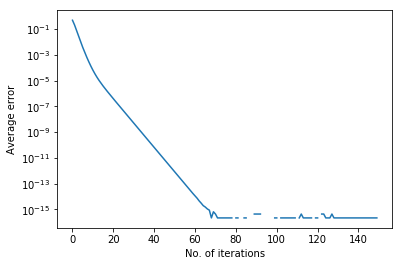

Wall time: 634 ms


In [7]:
%%time
#Implement centro PCA without dask
power=power(A,x_init,Eigvec)
plt.plot(power)
plt.yscale('log')
plt.xlabel('No. of iterations')
plt.ylabel('Average error')
plt.show()

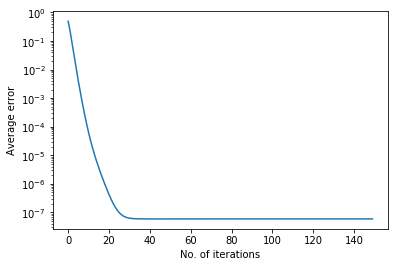

Wall time: 731 ms


In [8]:
%%time
n=NumberOfNodes # number of chunks
chunk_size=int(N/n)
# power method parallel without dask
power_wo=power_parallel(s,dim,VarianceConditioning,n,chunk_size,x_init,Eigvec)
plt.plot(power_wo)
plt.yscale('log')
plt.xlabel('No. of iterations')
plt.ylabel('Average error')
plt.show()

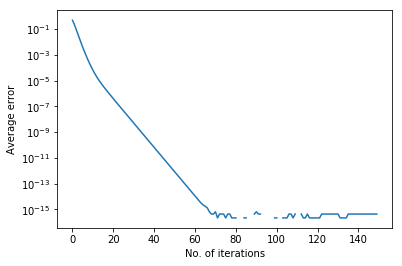

Wall time: 29.1 s


In [9]:
%%time
# power method using dask
Ai = da.from_array(data, chunks=(dim,chunk_size,))
power_dask=power_dask(Ai,x_init,Eigvec)
plt.plot(power_dask)
plt.yscale('log')
plt.xlabel('No. of iterations')
plt.ylabel('Average error')
plt.show()